# <ins>Sentiment Analysis: "Covid Vaccine" on Twitter</ins>

# Exploratory Data Analysis

## Overview
With any form of unstructured text data, there exists an abundance of information to extrapolate. In this case, working with tweets about the Covid vaccine, the concepts I wanted explore are 1) what the breakdown of sentiment over time has been this year, 2) what sorts of words are common in each of the three classes (positive, negative, neutral) and how they resemble one another or more likely differ, and 3) ideally extract the distict features from each to help address the lack of trust in the vaccines that are now FDA approved.

Without having the time or the resources to manually tag all of the tweets I scraped, I began this process by using Valence Aware Dictionary and sEntiment Reasoner ([VADER](https://github.com/cjhutto/vaderSentiment)) to establish a baseline measure for classification and led to valuable insights. During the modeling process this will serve as my target variable when predicting classes on my test set and even tweets from future date ranges.

Using Matplotlib, Seaborn, and Wordclouds I created a number of visuals that help depict the data and provide insights to analysis. And then using a combination of Natural Language Toolkit ([NLTK](https://www.nltk.org/)) and [SpaCy](https://spacy.io/) I preprocessed the corpus in preparation for the modeling stage (found in the [modeling](https://github.com/davidlebruce/covid_vaccine_tweets/blob/main/04_modeling.ipynb) notebook).

In [1]:
# standard Python packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

# specialized NLP packages
from wordcloud import WordCloud
import spacy, re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from spacy.lang.en import English
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
nltk.download('wordnet')
nltk.download('stopwords')

# personalized functions and autoreload updates
from src.functions import * 
%load_ext autoreload
%autoreload 2

# optimize viewing
pd.set_option('max_colwidth', 150)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# unpickle the dataframe
df = pd.read_pickle('./data/clean_df.pkl')

In [3]:
# confirm shape and datatypes are intact
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77259 entries, 0 to 80729
Data columns (total 7 columns):
date         77259 non-null datetime64[ns]
tweet        77259 non-null object
username     77259 non-null object
link         77259 non-null object
nlikes       77259 non-null int64
nreplies     77259 non-null int64
nretweets    77259 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 4.7+ MB


## VADER Sentiment Classification
Using VADER allowed me to establish a basis for my classification without having to manually tag each of my tweets. The package was built and trained using social media-like text for sentiment analysis and is **particularly adept** at picking up on common social media trends like:

- emoticons (*happy*: ':)', *sad*: ':(', *angry*: '>:\[')
- acronyms ('LOL' and 'WTF')
- slang

**It is important to note that while VADER does a good job of picking up on the overall sentiment of a tweet by giving each tweet and giving it a percent positive, percent negative, percent neutral, and overall compound score, the machine cannot actually understand the language (in this case English).** There are a number of instances I noticed where the overall sentiment of a tweet clearly conveying negative sentiment, but the object of that negative sentiment was something other than the COVID-19 vaccine. So, while VADER may have correctly tagged a tweet as negative in its tone, it could and should probably be tagged as a tweet with positive sentiment towards a vaccine. With more time I would ideally like to have a crowd-sourced voting system to classify tweets as ground truth for our classification.

In [4]:
# use vader compound (or composite) score to evaluate the tweet sentiment
vader = SentimentIntensityAnalyzer()

df['vader_score'] = df['tweet'].apply(lambda x: vader.polarity_scores(x)['compound'])

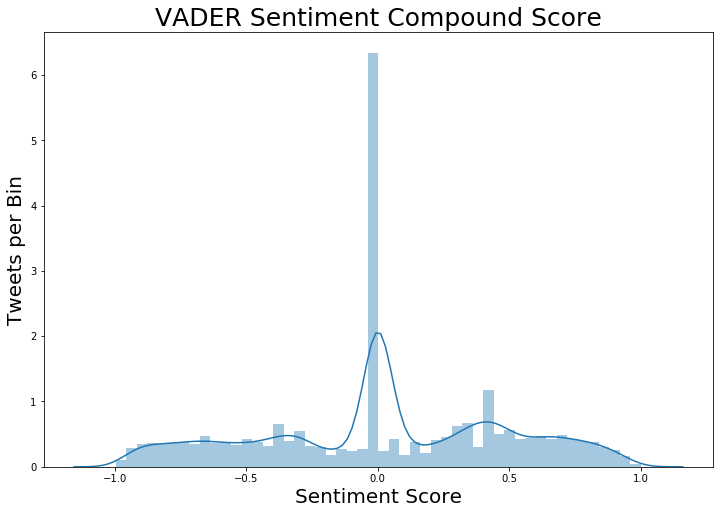

In [5]:
# plot the distribution of 'vader_score'
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.distplot(df['vader_score'])
plt.title('VADER Sentiment Compound Score', fontsize=25)
plt.xlabel('Sentiment Score', fontsize=20)
plt.ylabel('Tweets per Bin', fontsize=20)
plt.savefig('images/vader_sent_dist.png');

Looking at the graph above we see it follows a relatively normal curve, with an overwhelming amount of tweets hovering just below the net-neutral sentiment score and the rest of the tweets being more evenly distributed in both of the tails. 

Using VADER's recommended scoring method, I binned the tweets with a compound sentiment score below -.05 in the negative class, and those above .05 in the positive bin, with the remainder falling into the neutral bin.

In [6]:
# classify tweets based on their vader score less than -.05 'negative', greater than .05 'positive'
# 'neutral' in between
conditions = [
    df['vader_score'] >= .05,
    df['vader_score'] <= -.05
]

classes = ['positive', 'negative']

df['vader_sentiment'] = np.select(conditions, classes, 'neutral')

Binning the tweets by sentiment this way left me with a slight class imbalance, but I won't play around with the scoring too much, as it is relatively even.

In [7]:
# breakdown of classes
df.vader_sentiment.value_counts()

positive    31095
negative    25703
neutral     20461
Name: vader_sentiment, dtype: int64

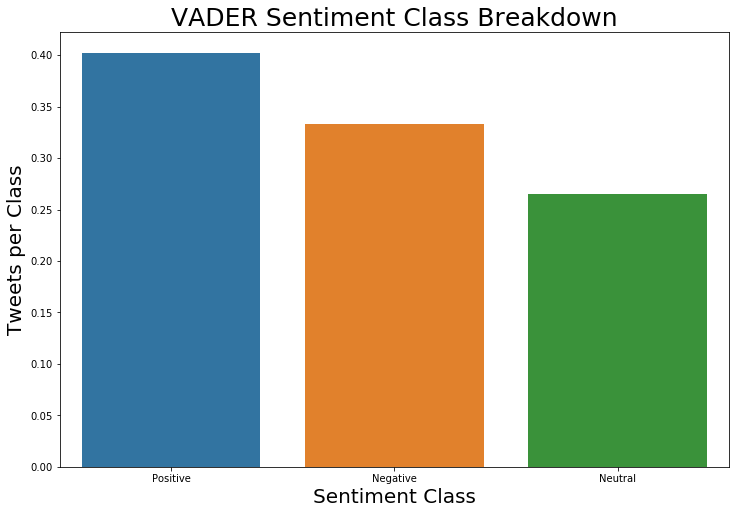

In [8]:
# plot breakdown of classes
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=['Positive', 'Negative', 'Neutral'], y=df['vader_sentiment'].value_counts(normalize=True))
plt.title('VADER Sentiment Class Breakdown', fontsize=25)
plt.xlabel('Sentiment Class', fontsize=20)
plt.ylabel('Tweets per Class', fontsize=20)
plt.savefig('images/class_bar.png');

The barchart above displays the class imbalance. My data is broken up into about **40% positive tweets, 35% negative tweets, and 25% neutral tweets.** This is nothing to worry about. It's not so dramatic of a difference that my classifier wouldn't be able to simply guess the majority class most of the time (that would prove especially difficult with a multiclass classification problem such as this).

## Text Preprocessing

Preprocessing text data is a multistep process. After much experimentation and exploration with the preprocessing tools available to me (NLTK, SpaCy, Regex) I ended up modifying a preprocessing function originally written by Zijing Zhu ([here](https://towardsdatascience.com/a-step-by-step-tutorial-for-conducting-sentiment-analysis-a7190a444366)) for preprocessing articles. With more time I would like to write my own original function that is highly specialized to help preprocessing twitter data and less time consuming or computationally expensive.

The function takes in a string of text, lemmatizes it if it is not punctuation, removes unneeded characters and empty strings, and then rejoins the words in lowercase that are not part of my updated stopwords list. 

In [9]:
# instantiate spacy english
nlp = English()

# update stopwords
stop_words = list(set(stopwords.words('english')))
stop_words.extend(['covid', '#covid', 'virus', '#virus',
                   'coronavirus', '#coronavirus', 'vaccine',
                   '#vaccine', 'vaccines', '#vaccines', 'covid-19'])
stop_words = [w.lower() for w in stop_words]

In [10]:
def tweet_preprocessing(str_input):
    
    # tokenization, remove punctuation, lemmatization
    words=[token.lemma_ for token in nlp(str_input) if not token.is_punct]
 
    # remove symbols, websites, email addresses 
    words = [re.sub(r'[^A-Za-z@]', '', word) for word in words] 
    words = [re.sub(r'\S+com', '', word) for word in words]
    words = [re.sub(r'\S+@\S+', '', word) for word in words] 
    words = [word for word in words if word!=' ']
    words = [word for word in words if len(word)!=0] 
 
    # remove stopwords     
    words=[word.lower() for word in words if (word.lower() not in stop_words) & 
                                                       (len(word.lower()) > 1)]
    
    # combine a list into one string   
    string = ' '.join(words)
    
    return string

In [11]:
# apply tweet_preprocessing function to tweets
df['clean_tweets'] = df['tweet'].apply(lambda x: tweet_preprocessing(x))

In [12]:
df['clean_tweets'].head(3)

0    everyone compare flu reminder even flu kill ten thousand year imagine much deadly assurance develope affordable hello pandemic
1            perhaps much type medicine success depend cooperation everyone protect young promise need massive buy population large
2                     provide pharmaceutical company opportunity develop drug soon possible reach mass production know drug produce
Name: clean_tweets, dtype: object

In [13]:
# saving dataframe with preprocessed tweets for use in modeling
df.to_pickle('data/modeling_df.pkl')

## Wordclouds, Frequency Distributions, and Bar Charts
These visuals will help me to get a clearer understanding of what kinds of words are pervasive throughout the data.

In [14]:
clean_tweets = df['clean_tweets']

In [15]:
# instantiate tokenizer
tokenizer = TweetTokenizer(strip_handles=True)

# make one large string of text
all_words = ' '.join(clean_tweets)

# tokenize the large string for analysis
all_tokens = tokenizer.tokenize(all_words)

In [16]:
len(all_tokens)

1076627

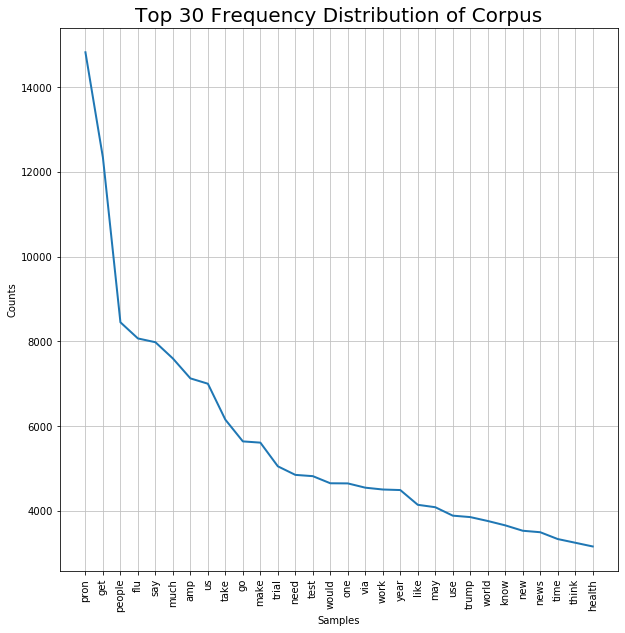

<Figure size 432x288 with 0 Axes>

In [17]:
# plot frequency distribution
fdist = FreqDist(all_tokens)
plt.figure(figsize=(10,10))
plt.title('Top 30 Frequency Distribution of Corpus', fontsize=20)
fdist.plot(30)
plt.savefig('images/first_fdist.png');

In [18]:
# update stopwords with meaningless top words
stop_words.extend(['get', 'people', 'say', 'much', 'amp',
                   'take', 'go', 'make', 'need', 'would',
                   'one', 'via', 'like', 'may', 'use',
                   'know'])

In [19]:
# remove new stopwords     
all_tokens = [word for word in all_tokens if word not in stop_words]

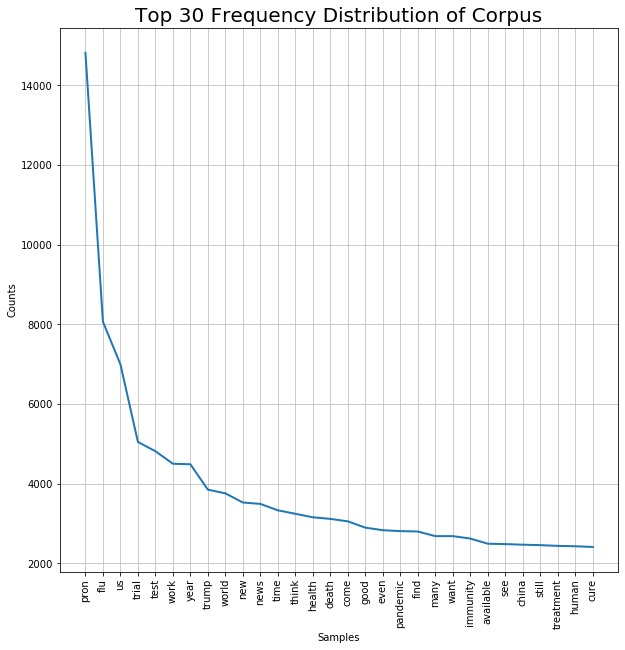

<Figure size 432x288 with 0 Axes>

In [20]:
# updated fdist
fdist = FreqDist(all_tokens)
plt.figure(figsize=(10,10))
plt.title('Top 30 Frequency Distribution of Corpus', fontsize=20)
fdist.plot(30)
plt.savefig('images/second_fdist.png');

In [21]:
# update stopwords with meaningless top words
stop_words.extend(['pron', 'come', 'even', 'many',
                   'see', 'still'])

In [22]:
# remove new stopwords     
all_tokens = [word for word in all_tokens if word not in stop_words]

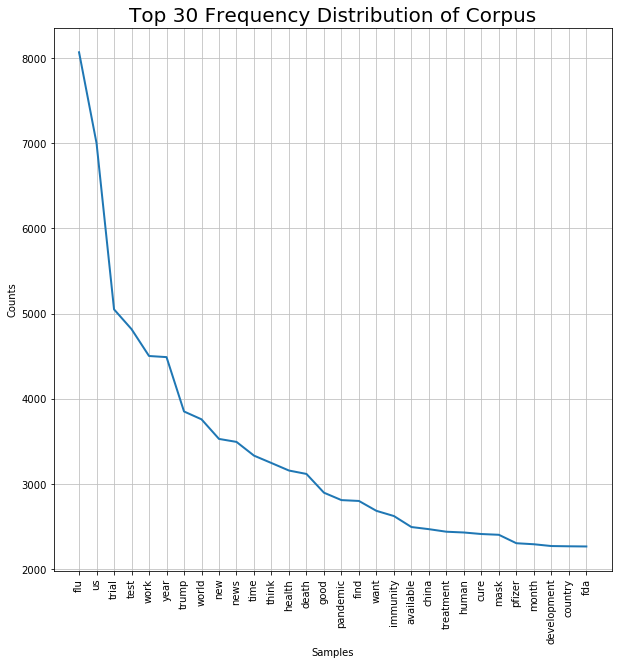

<Figure size 432x288 with 0 Axes>

In [23]:
# updated fdist
fdist = FreqDist(all_tokens)
plt.figure(figsize=(10,10))
plt.title('Top 30 Frequency Distribution of Corpus', fontsize=20)
fdist.plot(30)
plt.savefig('images/third_fdist.png');

After a couple of iterations of removing stopwords of little or no significance, we finally see here a frequency distribution of lemmatized and lowercased tokens that make sense in the context of the problem. I would expect to see all of these words in tweets concerning the covid vaccine. Now let's see if there are any notable distinctions between the classes.

# Exploring More Extreme VADER Scoring
Simply in the name of exploration and a desire to see what exists at the more extreme poles of this sentiment scale, I've made two groups of highly positive and highly negative tweets, where I adjusted the thresholds for those sentiments to 0.5 and -0.5. Hopefully this will help me understand what the more intense ideologies are at play in this discussion over a Coronavirus vaccine.

In [24]:
# higher threshold for higher class distinction
highly_pos = df[df['vader_score'] >= .5]
highly_neg = df[df['vader_score'] <= -.5]

In [25]:
# separate extreme clean tweets
clean_pos_tweets = highly_pos['clean_tweets']
clean_neg_tweets = highly_neg['clean_tweets']

# make one large string of text
all_pos_words = ' '.join(clean_pos_tweets)
all_neg_words = ' '.join(clean_neg_tweets)

# tokenize the large string for analysis
all_pos_tokens = tokenizer.tokenize(all_pos_words)
all_neg_tokens = tokenizer.tokenize(all_neg_words)

# remove stop words
all_pos_tokens = [word for word in all_pos_tokens if word not in stop_words]
all_neg_tokens = [word for word in all_neg_tokens if word not in stop_words]

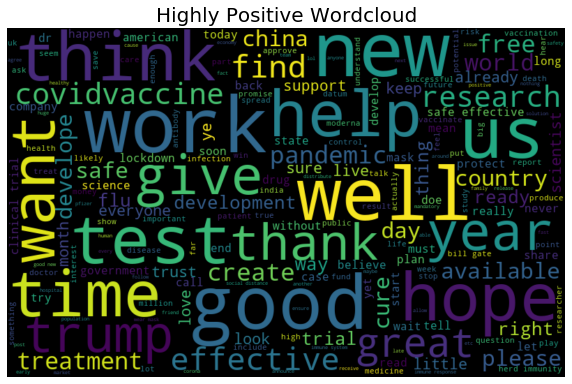

In [26]:
# rejoin all positive tokens without stops
pos_cloud = ' '.join([token for token in all_pos_tokens])

# instantiate wordcloud
wordcloud = WordCloud(width=800, height=500, random_state=88, max_font_size=110).generate(pos_cloud)

# plot cloud
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Highly Positive Wordcloud', fontsize=20)
plt.savefig('images/highly_pos_cloud.png');

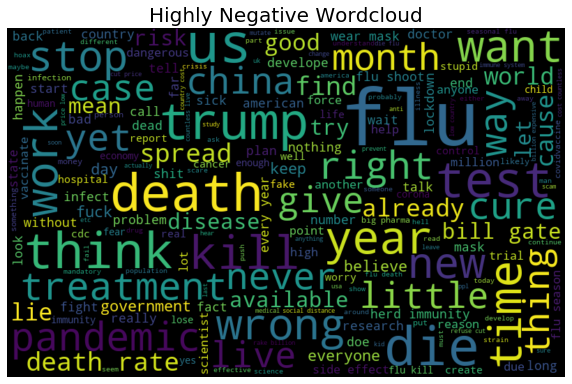

In [27]:
# rejoin all positive tokens without stops
neg_cloud = ' '.join([token for token in all_neg_tokens])

# instantiate wordcloud
wordcloud = WordCloud(width=800, height=500, random_state=88, max_font_size=110).generate(neg_cloud)

# plot cloud
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Highly Negative Wordcloud', fontsize=20)
plt.savefig('images/highly_neg_cloud.png');

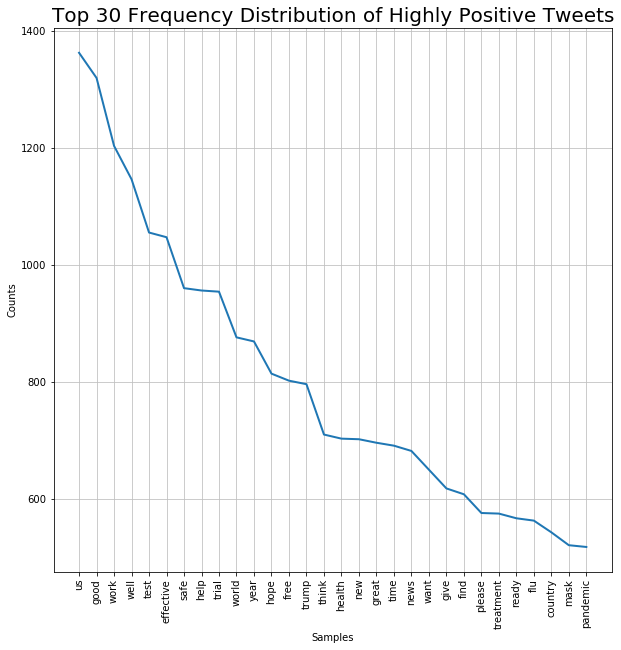

<Figure size 432x288 with 0 Axes>

In [28]:
# updated fdist
fdist = FreqDist(all_pos_tokens)
plt.figure(figsize=(10,10))
plt.title('Top 30 Frequency Distribution of Highly Positive Tweets', fontsize=20)
fdist.plot(30)
plt.savefig('images/pos_fdist.png');

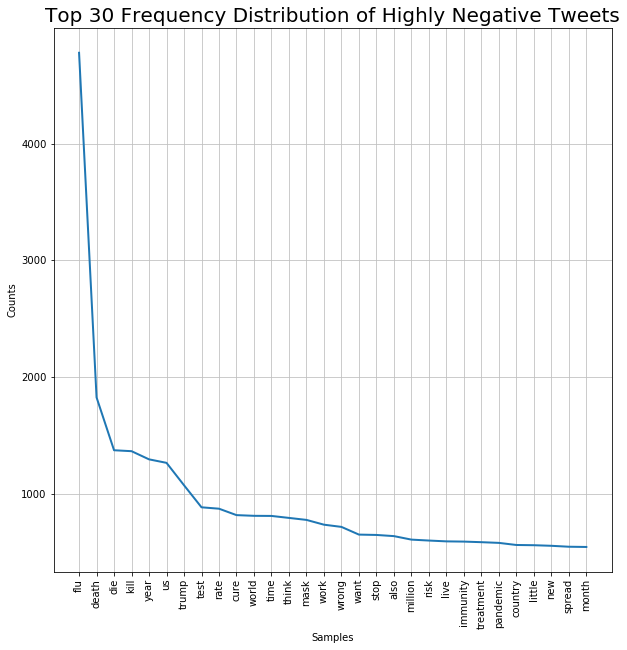

<Figure size 432x288 with 0 Axes>

In [32]:
# updated fdist
fdist = FreqDist(all_neg_tokens)
plt.figure(figsize=(10,10))
plt.title('Top 30 Frequency Distribution of Highly Negative Tweets', fontsize=20)
fdist.plot(30)
plt.savefig('images/neg_fdist.png', bbox_inches='tight');

When looking at the most frequent words in sentiment analysis, the temptation is to read between the lines and see what you want to see. To me there seems to be a clear divide between the negative and positive tweets. In the positive tweets we see words like 'effective,' 'safe,' 'help,' 'treatment,' and 'ready.' On the negative tweets we see more words like 'flu,' 'test,' 'rate,' 'immunity,' and 'spread.' From my perspective these match up with the narratives in my mind that people against a vaccine are wanting to wait out for herd immunity at great cost. I will need further analysis, more data, and more opinions to weigh in on my conclusions. 

## Sentiment Over Time

In [30]:
# setup a new dataframe with a compound index of date and sentiment classes
df_time = df.set_index(['date', 'vader_sentiment'])

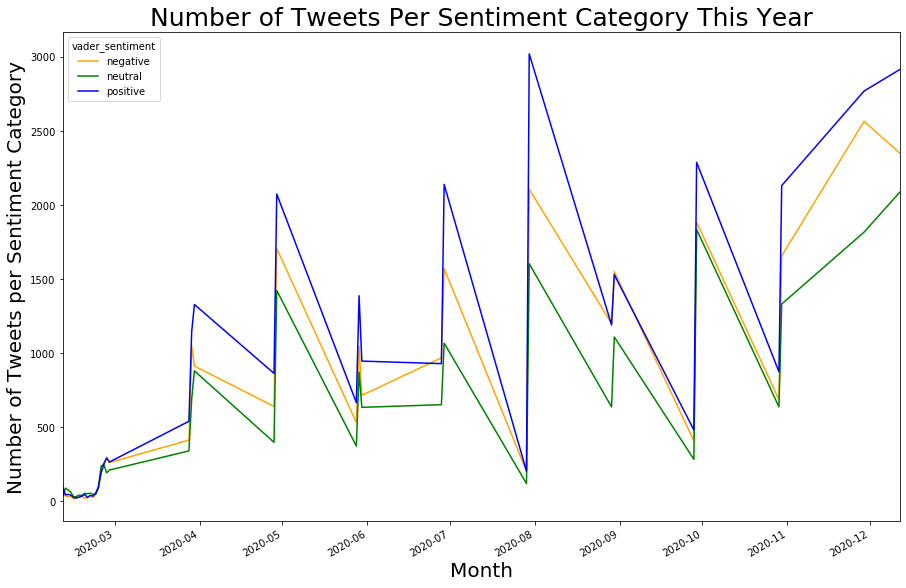

In [31]:
# plot tweet sentiment over time
fig, ax = plt.subplots(figsize=(15,10))
df_time.groupby(['date', 'vader_sentiment']).count()['tweet'].unstack().plot(
    ax=ax, color=('orange', 'green', 'blue'))
plt.title('Number of Tweets Per Sentiment Category This Year', fontsize=25)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of Tweets per Sentiment Category', fontsize=20)
plt.savefig('images/sentiment_over_time_line.png');

Key takeaways from this graph:
1) There is almost no tweeting about any vaccine until the **end of March when COVID-19 really began** to overwhelm the U.S.

2) The end of June and the beginning of September are the **only points at which we see the amount of negative tweets exceeding the amount of positive tweets**, otherwise the lines don't seem to cross each other and follow the same general trends

3) There is a **general upward trend** of more and more tweets about the COVID-19 vaccine as it gets closer and closer to being approved by the FDA for the public in early December

In the next notebook [04_modeling](https://github.com/davidlebruce/covid_vaccine_tweets/blob/main/04_modeling.ipynb), I'll take my preprocessed data from here and do some classification modeling.
